# Forecasting Analysis

This analyis was conducted to predict for the occurrence of downtime within the next week of the time period provided in the source dataset.

## Contents
- [Import Packages and Load Data](#Import-Packages-and-Load-Data)
- [Build Models](#Build-Models)
- [Plot Forecast](#Plot-Forecast)
- [Forecasted Change and Uncertainty](#Forecasted-Change-and-Uncertainty)
- [Conclusion](#Conclusion)

## Import Packages and Load Data

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
# Load the sheets
xls = pd.ExcelFile(r'../phase-1/clean_data_final.xlsx')
line_downtime_df = xls.parse('Line_downtime')
line_productivity_df = xls.parse('Line_productivity')

# Merge on 'Batch'
merged_df = pd.merge(line_downtime_df, line_productivity_df[['Batch', 'Date']], on='Batch', how='left')

# Convert date to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Group by Date and sum Minutes
downtime_df = merged_df.groupby('Date')['Minutes'].sum().reset_index()
downtime_df = downtime_df.sort_values('Date')
downtime_df.rename(columns={"Date": "ds", "Minutes":"y"}, inplace=True)

batch_df = merged_df.groupby('Date')["Batch"].nunique().reset_index()
batch_df = batch_df.sort_values('Date')
batch_df.rename(columns={"Date": "ds", "Batch":"y"}, inplace=True)

print(downtime_df)
print("-" * 50)
print(batch_df)

          ds    y
0 2024-08-29  244
1 2024-08-30  444
2 2024-08-31  165
3 2024-09-02  503
4 2024-09-03   32
--------------------------------------------------
          ds   y
0 2024-08-29   6
1 2024-08-30  12
2 2024-08-31   5
3 2024-09-02  11
4 2024-09-03   1


In [3]:
# Remove the last day from both data frames
downtime_df = downtime_df[:-1]
batch_df = batch_df[:-1]

## Build Models

In [4]:
# Downtime model
downtime_model = Prophet()
downtime_model.fit(downtime_df)

23:53:28 - cmdstanpy - INFO - Chain [1] start processing
23:53:28 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Batch model
batch_model = Prophet()
batch_model.fit(batch_df)

23:53:28 - cmdstanpy - INFO - Chain [1] start processing
23:53:28 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Future dates
future_dates = downtime_model.make_future_dataframe(periods=1)

# Downtime forecast
downtime_forecast = downtime_model.predict(future_dates)

# Batch forecast
batch_forecast = batch_model.predict(future_dates)

## Plot Forecast

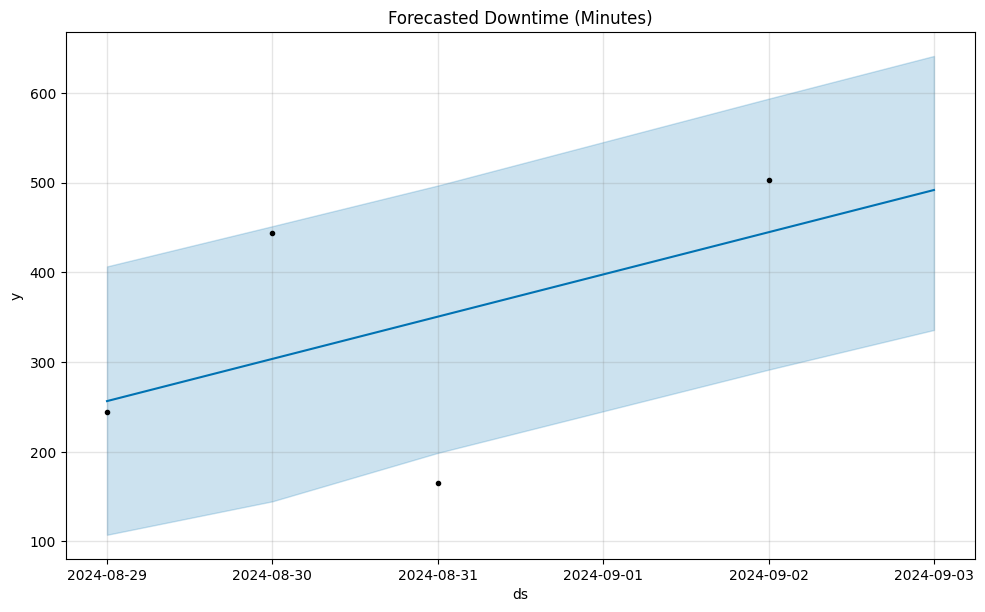

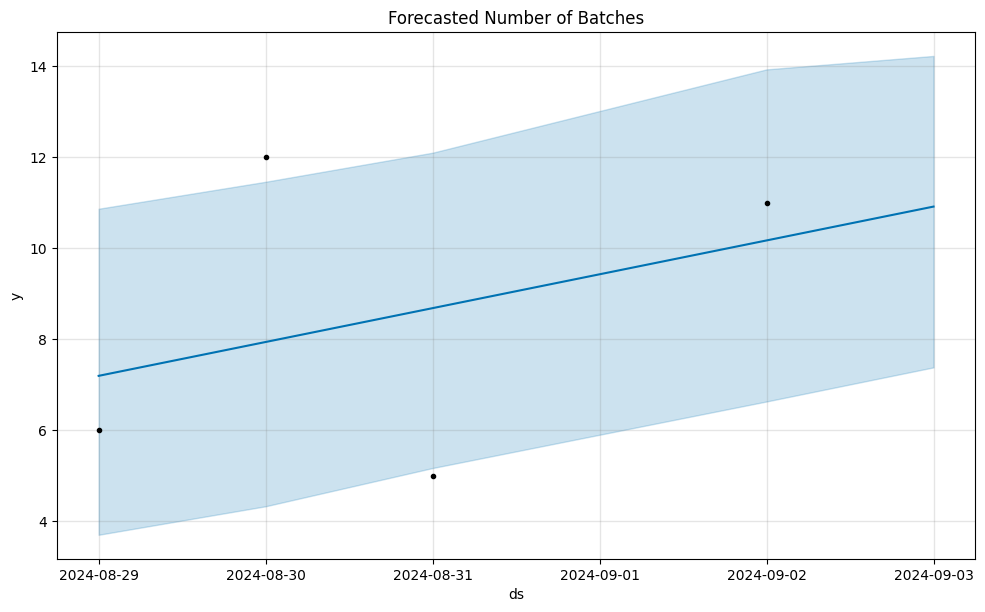

In [7]:
# Visualize both forecasts
downtime_model.plot(downtime_forecast)
plt.title("Forecasted Downtime (Minutes)")
plt.show()

batch_model.plot(batch_forecast)
plt.title("Forecasted Number of Batches")
plt.show()

## Forecasted Change and Uncertainty

In [8]:
# Calculate recent actual sums (last day)
recent_actual_downtime = downtime_df.tail(1)['y'].sum()
recent_actual_batches = batch_df.tail(1)['y'].sum()

# Get forecasted values for the next day
future_downtime = downtime_forecast[downtime_forecast['ds'] > downtime_df['ds'].max()].head(1)
future_batches = batch_forecast[batch_forecast['ds'] > batch_df['ds'].max()].head(1)

forecasted_downtime = future_downtime['yhat'].sum()
forecasted_batches = future_batches['yhat'].sum()

# Calculate percentage change
downtime_change_pct = ((forecasted_downtime - recent_actual_downtime) / recent_actual_downtime) * 100
batch_change_pct = ((forecasted_batches - recent_actual_batches) / recent_actual_batches) * 100

# Print results
print(f"\n📉 Forecasted % change in downtime (next day): {downtime_change_pct:.2f}%")
print(f"📦 Forecasted % change in number of batches (next day): {batch_change_pct:.2f}%")



📉 Forecasted % change in downtime (next day): -2.25%
📦 Forecasted % change in number of batches (next day): -0.79%


In [10]:
# Print predictions for the next day
next_day_downtime = downtime_forecast[downtime_forecast['ds'] > downtime_df['ds'].max()]
next_day_batches = batch_forecast[batch_forecast['ds'] > batch_df['ds'].max()]

print("\n📉 Forecasted Downtime (next day):")
print(next_day_downtime[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

print("\n📦 Forecasted Batch Count (next  day):")
print(next_day_batches[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


📉 Forecasted Downtime (next day):
          ds        yhat  yhat_lower  yhat_upper
4 2024-09-03  491.695075  335.726794  641.107627

📦 Forecasted Batch Count (next  day):
          ds       yhat  yhat_lower  yhat_upper
4 2024-09-03  10.913385     7.38168   14.222163


## Conclusion

- Downtime is forecasted to drop by -2.25%.
- The number of produced batches is expected to drop by -0.79%.
- There is a high level of uncertainty in the forecast results probably because the size of the historical data is very small.